# **Autoencoders para eliminar ruido**

In [1]:
COLAB = True

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.datasets import mnist

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

In [3]:
def plot_image(image, cmap="binary"):
    plt.imshow(image, cmap=cmap)
    plt.axis("off")

def show_model(model):
    if not COLAB:
        display(SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg')))
    else:
        display(SVG(model_to_dot(model, show_shapes=True, dpi=72).create(prog='dot', format='svg')))

In [4]:
(X_trval, y_trval), (X_test, y_test) = mnist.load_data()

X_train, X_valid = X_trval[:-5000], X_trval[-5000:]
y_train, y_valid = y_trval[:-5000], y_trval[-5000:]

11490434/11490434 [==============================] - 1s 0us/step


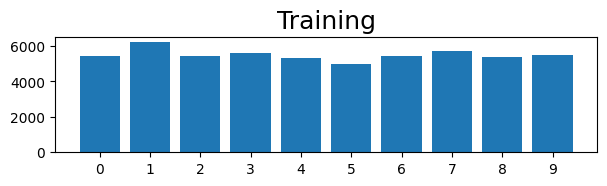

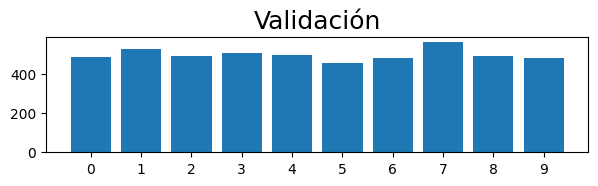

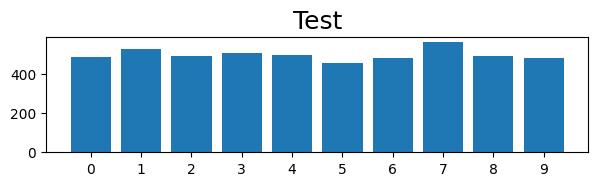

In [5]:
def show_ests(y, title=None):
    clases, counts = np.unique(y, return_counts=True)
    plt.figure(figsize=(7,1.5))
    plt.bar(clases, counts)
    if title:
        plt.title(title, fontsize=18)
    plt.xticks(clases)
    plt.show()

show_ests(y_train, title="Training")
show_ests(y_valid, title="Validación")
show_ests(y_valid, title="Test")

In [6]:
X_train = X_train.astype('float32') / 255
X_valid = X_valid.astype('float32') / 255
X_test = X_test.astype('float32') / 255
print(X_train.shape)
print(X_test.shape)

(55000, 28, 28)
(10000, 28, 28)


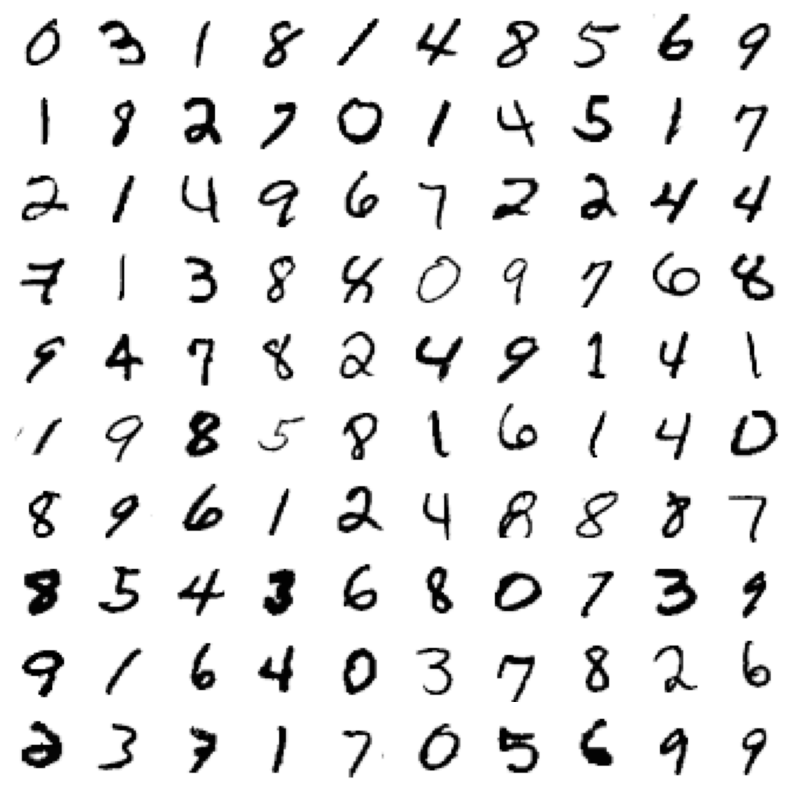

In [7]:
nrows=10
ncols=10

inds = np.random.randint(0, len(X_train), nrows*ncols)

plt.figure(figsize=(10,10/ncols*nrows))
for i,ind in enumerate(inds):
    plt.subplot(nrows, ncols, i+1)
    plot_image(X_train[ind], cmap="Greys")

In [8]:
noise_factor = 0.5
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_valid_noisy = X_valid + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_valid.shape)
X_test_noisy  = X_test  + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape) 

X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_valid_noisy = np.clip(X_valid_noisy, 0., 1.)
X_test_noisy  = np.clip(X_test_noisy, 0., 1.)

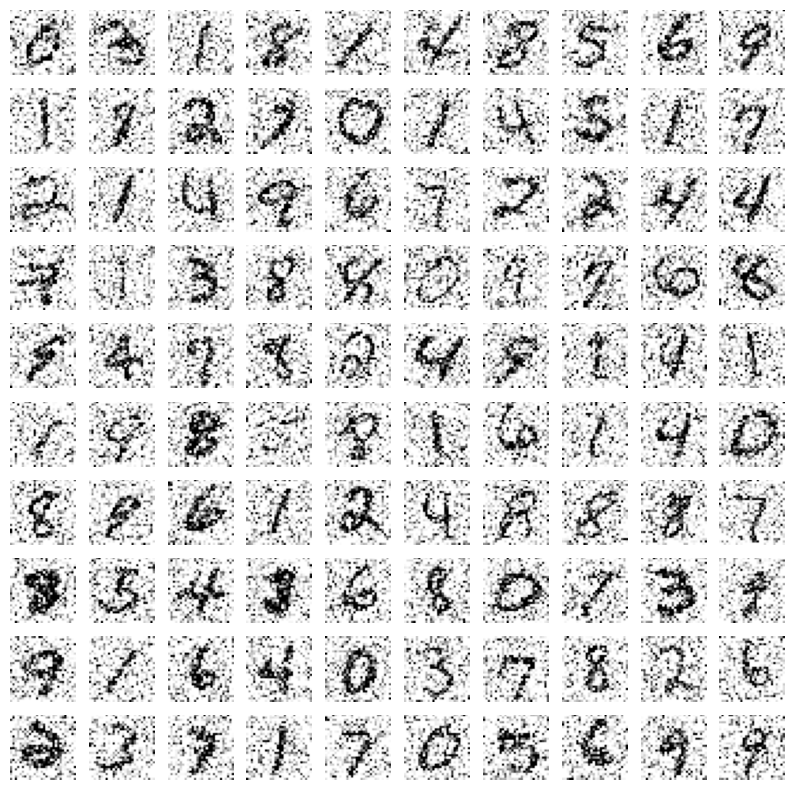

In [9]:
plt.figure(figsize=(10,10/ncols*nrows))
for i,ind in enumerate(inds):
    plt.subplot(nrows, ncols, i+1)
    plot_image(X_train_noisy[ind], cmap="Greys")

If you squint you can still recognize them, but barely. Can our autoencoder learn to recover the original digits? Let's find out.

Compared to the previous convolutional autoencoder, in order to improve the quality of the reconstructed, we'll use a slightly different model with more filters per layer:

In [10]:
# This is our input image
input_img = keras.Input(shape=(28,28,))

# "encoded" is the encoded representation of the input
encoded = layers.Reshape((28,28,1))(input_img)
encoded = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
encoded = layers.MaxPooling2D((2, 2), padding='same')(encoded)
encoded = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
encoded = layers.MaxPooling2D((2, 2), padding='same')(encoded)

# at this point the representation is (7, 7, 32)

# "decoded" is the lossy reconstruction of the input
decoded = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded) # operador para extraer características relevantes de los datos de entrada, con padding dejeando los pixeles como estaban
decoded = layers.UpSampling2D((2, 2))(decoded) # operador para aumentar el tamaño de la imagen: replicando los pixeles
decoded = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(decoded)
decoded = layers.UpSampling2D((2, 2))(decoded)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(decoded)
decoded = layers.Reshape([28,28])(decoded)

In [11]:
# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)

# Create the decoder model
decoder = keras.Model(encoded, decoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                         

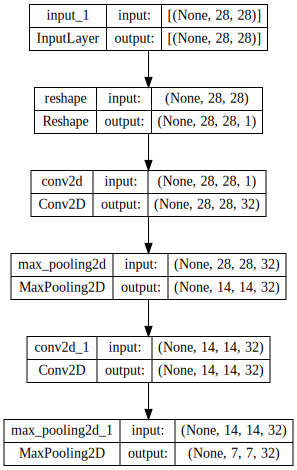

In [12]:
encoder.summary()
show_model(encoder)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 7, 7, 32)]        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 32)          9248      
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 up_sampling2d_1 (UpSampling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 1)         289 

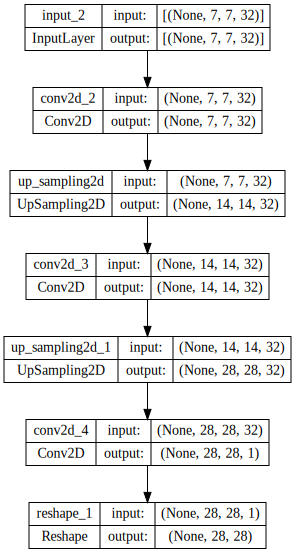

In [13]:
decoder.summary()

show_model(decoder)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                       

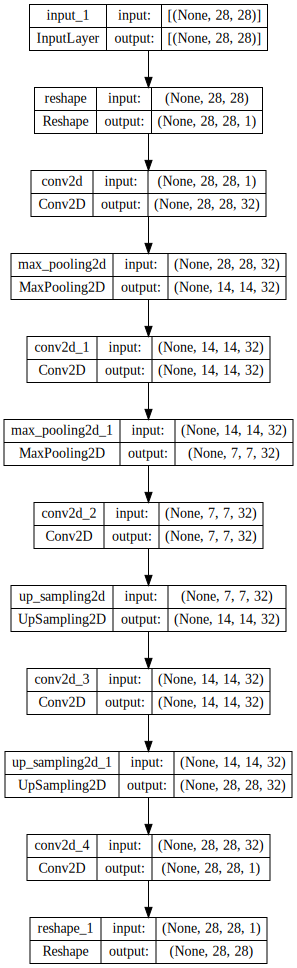

In [14]:
autoencoder.summary()

show_model(autoencoder)

In [15]:
# configure the model to use a per-pixel binary crossentropy loss
# and the Adam optimizer:

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [16]:
autoencoder.fit(X_train_noisy, X_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(X_valid_noisy, X_valid))

Epoch 1/100
430/430 [==============================] - 15s 8ms/step - loss: 0.1709 - val_loss: 0.1206
Epoch 2/100
430/430 [==============================] - 3s 7ms/step - loss: 0.1139 - val_loss: 0.1121
Epoch 3/100
430/430 [==============================] - 3s 7ms/step - loss: 0.1081 - val_loss: 0.1090
Epoch 4/100
430/430 [==============================] - 3s 6ms/step - loss: 0.1051 - val_loss: 0.1054
Epoch 5/100
430/430 [==============================] - 3s 6ms/step - loss: 0.1030 - val_loss: 0.1031
Epoch 6/100
430/430 [==============================] - 3s 6ms/step - loss: 0.1014 - val_loss: 0.1017
Epoch 7/100
430/430 [==============================] - 3s 7ms/step - loss: 0.1003 - val_loss: 0.1009
Epoch 8/100
430/430 [==============================] - 3s 6ms/step - loss: 0.0994 - val_loss: 0.1003
Epoch 9/100
430/430 [==============================] - 3s 6ms/step - loss: 0.0987 - val_loss: 0.0995
Epoch 10/100
430/430 [==============================] - 3s 6ms/step - loss: 0.0982 - val_l

In [17]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(X_test_noisy)
decoded_imgs = decoder.predict(encoded_imgs)

313/313 [==============================] - 1s 2ms/step


In [18]:
encoded_imgs.shape

(10000, 7, 7, 32)

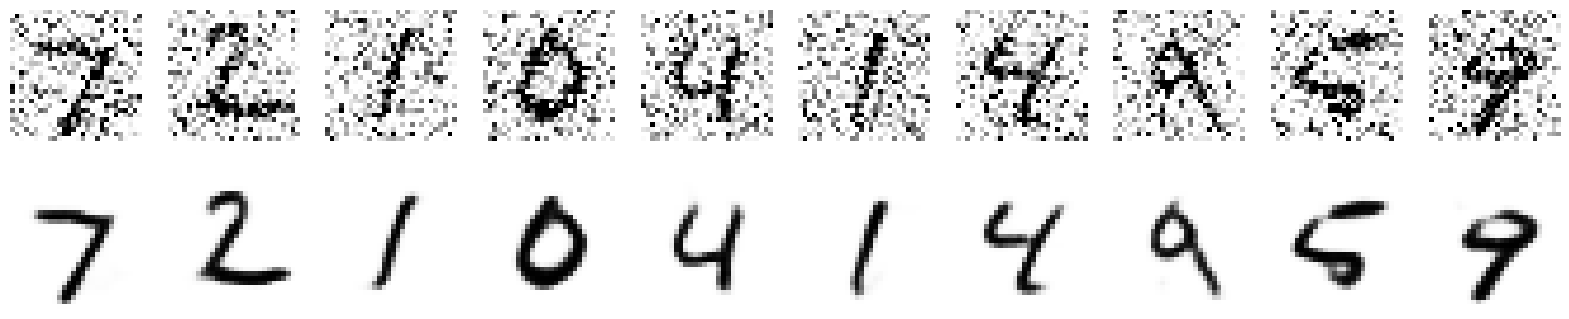

In [19]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plot_image(X_test_noisy[i], cmap="Greys")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plot_image(decoded_imgs[i], cmap="Greys")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

It seems to work pretty well. If you scale this process to a bigger convnet, you can start building document denoising or audio denoising models. Kaggle has an interesting dataset about this: https://www.kaggle.com/c/denoising-dirty-documents

**Imágenes sin ruido**

In [20]:
n = 10

encoded_imgs = encoder.predict(X_test[:n])
encoded_imgs.min(), encoded_imgs.max(), encoded_imgs.mean(), encoded_imgs.std()

1/1 [==============================] - 0s 73ms/step


(0.0, 1.4851837, 0.11207968, 0.19274996)

In [21]:
encoded_imgs.shape

(10, 7, 7, 32)

**Imágenes con ruido**

In [22]:
encoded_noisy_imgs = encoder.predict(X_test_noisy[:n])
encoded_noisy_imgs.min(), encoded_noisy_imgs.max(), encoded_noisy_imgs.mean(), encoded_noisy_imgs.std()

1/1 [==============================] - 0s 17ms/step


(0.0, 1.1571318, 0.12860984, 0.18515313)

In [23]:
encoded_noisy_imgs.shape

(10, 7, 7, 32)

## Detección de anomalías en test

In [24]:
differences = np.array(X_test - autoencoder(X_test))

differences.shape

(10000, 28, 28)

In [25]:
differences_flat = differences.reshape(len(differences), -1)

differences_flat.shape

(10000, 784)

In [26]:
errors = (np.array(differences_flat)**2).mean(axis=1)

errors.shape

(10000,)

In [27]:
inds_maximos = np.argsort(errors)[::-1]

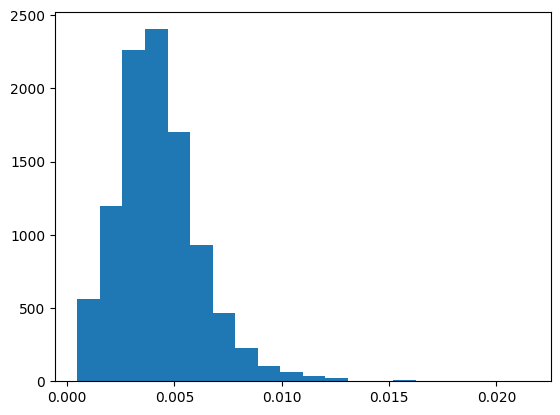

In [28]:
plt.hist(errors, bins=20);

In [29]:
def show_error(error):
    img = np.zeros((error.shape[0],error.shape[1],3))
    img[:,:,1] = np.clip(error, 0, 1)
    img[:,:,2] = np.clip(error, 0, 1)

    img[:,:,0] = -np.clip(error, -1, 0)
    img[:,:,1] = img[:,:,1] - np.clip(error, -1, 0)
    
    plt.imshow(1-img, vmin=0, vmax=1)
    plt.axis("off")

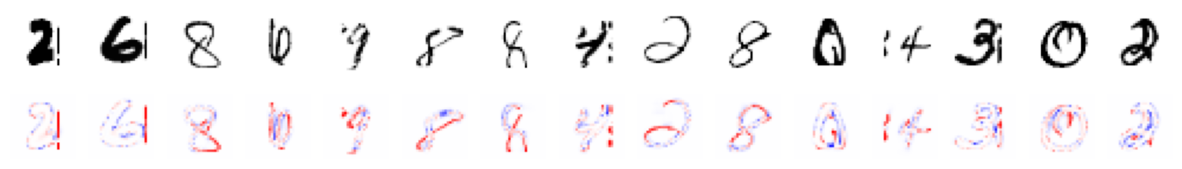

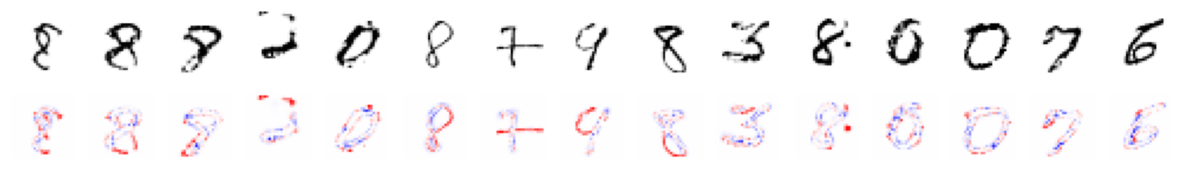

In [30]:
ncols=15
nrows=2

aux = 1
for i,ind in enumerate(inds_maximos[:(nrows*ncols)]):
    if aux == 1:
        plt.figure(figsize=(15,15/ncols*nrows))
    plt.subplot(2, ncols, aux)
    plot_image(X_test[ind], cmap="Greys")
    plt.subplot(2, ncols, ncols + aux)
    show_error(differences[ind])
    if aux == ncols:
        plt.show()
        aux = 1
    else:
        aux = aux + 1